## Desafio

O seguinte script realiza todo o processo de extração, transformação, carga e consequente análise dos dados para responder as perguntas propostas no desafio.
A escolha pela entrega em formato Jupyter Notebook foi feita para facilitar a explicação (storytelling) de cada etapa do código, e poder alterar a análise entre a linguagem SQL e Python. 


Realizado por: Vitor Klein

Data: 03/12/2021

## Etapa 1:
A primeira etapa consiste na leitura de ambos arquivos em excel, localizados dentro do diretório data. 

Após a leitura, cada arquivo passará por etapas de transformação e conformidade dos dados, buscando prepará-los para a carga no banco relacional SQLite.

In [1]:
import pandas as pd

FILE_PATH_PIB = 'D:\OneDrive - K Data BI\K Data BI\Python_Projects\desafio_eleflow\data\PIB_Cepea.xlsx'

df_pib = pd.read_excel(FILE_PATH_PIB, sheet_name='PIB', header=7, index_col=0)
df_pib.head()

,(A) Insumos,(B) Agropecuária,(C) Indústria,(D) Serviços,Agronegócio Total (A+B+C+D),Unnamed: 6,(A) Insumos.1,(B) Agropecuária .1,(C) Indústria.1,(D) Serviços.1,...,(B) Agropecuária .4,(C) Indústria.4,(D) Serviços.4,Ramo Agrícola (A+B+C+D).1,Unnamed: 30,(A) Insumos.5,(B) Agropecuária .5,(C) Indústria.5,(D) Serviços.5,Ramo Pecuário (A+B+C+D).1
1996,31597.663029,200211.777672,514755.882623,646536.982537,1.393102e+06,NaN,22563.193281,156660.677117,412869.927639,453820.180455,...,30626.503975,80714.335676,88719.938000,204471.787111,NaN,1766.200866,8514.057125,19918.276001,37675.324872,67873.858865
1997,32825.998197,199911.301734,482894.842674,604714.559307,1.320347e+06,NaN,24380.354954,155492.922112,387664.454315,422442.885968,...,32747.697761,81644.348890,88968.885293,208495.573987,NaN,1778.700719,9354.764520,20056.063860,38387.455763,69576.984862
1998,31818.410647,200969.741431,455966.002147,576123.413175,1.264878e+06,NaN,23463.106415,157842.942734,369315.330228,408645.982407,...,34879.612613,81610.082955,90301.240684,211975.736080,NaN,1846.327557,9530.017660,19147.779539,37008.609985,67532.734741
1999,34784.067160,206952.587184,453199.228768,573119.731296,1.268056e+06,NaN,24784.952250,159184.070925,370986.897917,416017.500859,...,37993.742136,88546.425866,99294.241941,231750.033781,NaN,2386.569154,11401.295861,19622.278037,37496.852528,70906.995579
2000,40682.954859,209175.390473,496957.470676,626206.339831,1.373022e+06,NaN,28889.384804,147215.914768,411716.234016,463763.331603,...,37107.020740,103776.571025,116895.483696,265060.890085,NaN,2972.669424,15617.411702,21485.777144,40945.138880,81020.997150


A leitura do arquivo do PIB traz várias linhas e colunas que não serão utilizadas em nossa análise.

 Como precisamos somente dos dados relacionados ao PIB do Ramo Agrícola e Pecuário, extraíremos apenas as colunas com essa informação.

Também faremos a limpeza do dataframe com valores válidos (através da coluna Ano), e realizaremos a transformação de linhas em colunas, buscando as melhores práticas de modelagem dimensional. 

As primeiras linhas do dataframe são demonstradas a seguir.

In [2]:
df_pib= df_pib[['Ramo Agrícola (A+B+C+D).1', 'Ramo Pecuário (A+B+C+D).1']]
df_pib.reset_index(inplace=True)
df_pib.columns = ['Ano','Agrícola', 'Pecuário']
df_pib = df_pib[df_pib['Ano'].astype(str).str.isdigit()]
df_pib = pd.melt(df_pib, id_vars=['Ano'], var_name='Ramo',value_name='Valor',value_vars=['Agrícola', 'Pecuário'])
df_pib.head(10)

,Ano,Ramo,Valor
0,1996,Agrícola,204471.787111
1,1997,Agrícola,208495.573987
2,1998,Agrícola,211975.736080
3,1999,Agrícola,231750.033781
4,2000,Agrícola,265060.890085
5,2001,Agrícola,286242.021332
6,2002,Agrícola,340599.908962
7,2003,Agrícola,411175.992020
8,2004,Agrícola,415224.028690
9,2005,Agrícola,403524.132332


In [3]:
FILE_PATH_PRODUCAO = 'D:\OneDrive - K Data BI\K Data BI\Python_Projects\desafio_eleflow\data\produção_2019.xlsx'

df = pd.read_excel(FILE_PATH_PRODUCAO, sheet_name='area prod uf', header=5, index_col=0)

No segundo arquivo, temos duas informações distintas: Produção e Área.

A partir dele, criaremos dois dataframes, cada um contendo uma variável com a respectiva localização, ano e mês de referência.

Os dataframes também serão limpos e conformados para que sejam gravados no banco adequadamente.

In [4]:
df.reset_index(inplace=True)
df.columns = ['UF', 'Ano1', 'Março1', 'Junho1', 'Ano2','Março2','Junho2']
df_area = df[['UF', 'Ano1', 'Março1', 'Junho1']]
df_production = df[['UF', 'Ano2', 'Março2', 'Junho2']]
df_area = df_area.rename(columns={'Ano1':'Anual','Março1':'Março', 'Junho1':'Junho'})
df_production = df_production.rename(columns={'Ano2':'Anual','Março2':'Março', 'Junho2':'Junho'})
df_production['Ano'] = 2019
df_area['Ano'] = 2019
df_production = df_production[df_production['Anual'].notna()]
df_area = df_area[df_area['Anual'].notna()]
df_area = pd.melt(df_area, id_vars=['Ano','UF'], var_name='Mês',value_name='Valor',value_vars=['Março', 'Junho','Anual'])
df_production = pd.melt(df_production, id_vars=['Ano','UF'], var_name='Mês',value_name='Valor',value_vars=['Março', 'Junho','Anual'])
df_area['Valor'] = df_area['Valor'].str.replace(" ","")
df_area['Valor'] = df_area['Valor'].astype(int)
df_area.head(10)

,Ano,UF,Mês,Valor
0,2019,ACRE,Março,39352
1,2019,ALAGOAS,Março,80283
2,2019,AMAPÁ,Março,22442
3,2019,AMAZONAS,Março,22930
4,2019,BAHIA,Março,3107865
5,2019,CEARÁ,Março,961926
6,2019,DISTRITO FEDERAL,Março,161900
7,2019,ESPÍRITO SANTO,Março,22805
8,2019,GOIÁS,Março,5760424
9,2019,MARANHÃO,Março,1603084


In [5]:
df_production['Valor'] = df_production['Valor'].str.replace(" ","")
df_production['Valor'] = df_production['Valor'].astype(int)
df_production.head(10)

,Ano,UF,Mês,Valor
0,2019,ACRE,Março,85784
1,2019,ALAGOAS,Março,105458
2,2019,AMAPÁ,Março,60375
3,2019,AMAZONAS,Março,41420
4,2019,BAHIA,Março,9065031
5,2019,CEARÁ,Março,918483
6,2019,DISTRITO FEDERAL,Março,860900
7,2019,ESPÍRITO SANTO,Março,48761
8,2019,GOIÁS,Março,25295407
9,2019,MARANHÃO,Março,5359847


## Etapa 2:
Na segunda etapa, iremos criar um banco relacional para que os dados extraídos sejam armazenados.

Após a criação do banco e das tabelas, faremos a carga dos dataframes criados na etapa anterior.

In [6]:
import sqlite3

connection = sqlite3.connect('eleflow_database')
cursor = connection.cursor()

In [7]:
query1 = """
    CREATE TABLE IF NOT EXISTS pib(
        ano int,
        ramo varchar(30), 
        valor_pib numeric(14,2)) 
"""

query2 = """
    CREATE TABLE IF NOT EXISTS producao(
        ano integer,
        mes varchar(20),
        uf varchar(30),
        valor numeric(14,2)
    )
"""

query3 = """
    CREATE TABLE IF NOT EXISTS area(
        ano integer,
        mes varchar(20),
        uf varchar(30),
        valor numeric(14,2)
    )
"""

cursor.execute(query1)
cursor.execute(query2)
cursor.execute(query3)

In [8]:
df_pib.to_sql('pib', con=connection, if_exists='replace', index=False)
df_production.to_sql('producao', con=connection, if_exists='replace', index=False)
df_area.to_sql('area', con=connection, if_exists='replace', index=False)

## Etapa 3:

Com os dados limpos e armazenados em um banco relacional, podemos analisá-los buscando responder cada pergunta proposta no desafio.

Nesta etapa, utilizaremos SQL e Python.

In [9]:
# conexao ao banco SQLite
%load_ext sql
%sql sqlite:///eleflow_database

### Pergunta 1:

Qual a porcentagem de participação da região Centro-Oeste na produção nacional no primeiro semestre de 2019?

In [10]:
%%sql
SELECT SUM(Valor) * 100 / (SELECT SUM(Valor) FROM producao where Mês = 'Junho' and Ano = 2019) AS [Percentual do Centro Oeste]
FROM producao
WHERE UF in ('MATO GROSSO', 'MATO GROSSO DO SUL', 'GOIÁS', 'DISTRITO FEDERAL') and Mês = 'Junho' and Ano = 2019

 * sqlite:///eleflow_database
Done.


Percentual do Centro Oeste
46


### Pergunta 2:

Qual estado possui maior área produtiva? 

In [11]:
%%sql

SELECT UF , Valor as Area
FROM area
WHERE Valor = (SELECT MAX(Valor) FROM area where [Mês] = 'Anual')

 * sqlite:///eleflow_database
Done.


UF,Area
MATO GROSSO,16273085


### Pergunta 3:

Qual a média de produção mensal para o estado de São Paulo? 

In [12]:
%%sql

SELECT Valor/12 AS [Média de Produção Mensal]
FROM producao
WHERE UF = 'SÃO PAULO' AND Ano = 2019 AND Mês = 'Anual'

 * sqlite:///eleflow_database
Done.


Média de Produção Mensal
768736


### Pergunta 4:

Defina a correlação entre a produção agrícola e o PIB do Ramo Agrícola e Pecuário em 2019. Qual segmento possui maior correlação e qual possui menor correlação? Demonstre num gráfico e explique os coeficientes. 

In [13]:
pib_ramo_agricola = %sql SELECT valor FROM pib where ramo = 'Agrícola' and ano = 2019

 * sqlite:///eleflow_database
Done.


In [14]:
pib_ramo_pecuario = %sql SELECT valor FROM pib where ramo = 'Pecuário' and ano = 2019

 * sqlite:///eleflow_database
Done.


In [15]:
producao_agricola = %sql SELECT sum(valor) FROM producao WHERE ano = 2019 and [Mês] = 'Anual'

 * sqlite:///eleflow_database
Done.


In [16]:
data = [[pib_ramo_agricola[0][0],pib_ramo_pecuario[0][0],producao_agricola[0][0]]]
df = pd.DataFrame(data, columns = [ 'PIB Agrícola', 'PIB Pecuário', 'Produção Agrícola'])
df.head()

,PIB Agrícola,PIB Pecuário,Produção Agrícola
0,1.058239e+06,494755.934339,241462754


d:\OneDrive - K Data BI\K Data BI\Python_Projects\desafio_eleflow\.venv\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\OneDrive - K Data BI\K Data BI\Python_Projects\desafio_eleflow\.venv\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot:>

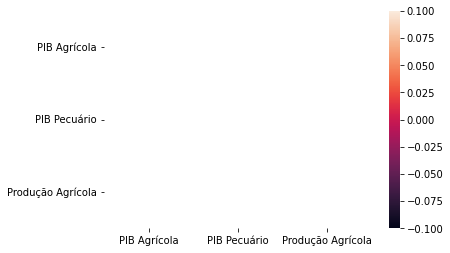

In [17]:
import seaborn as sns

correlation = df.corr()
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

OBS: Como demonstrado na imagem acima, não foi possível calcular a correlação entre as varíaveis. Como temos valores únicos para a produção agrícola à nível nacional (apenas dados de 2019), não podemos definir um nível de correlação com os dados do PIB (que detém a série histórica, e não são separados por UF).

Para isso, precisaríamos dos dados históricos da produção agrícola, assim como temos para o PIB (entre os anos de 1996 e 2019).